## Introduction

Topic Model: In a nutshell, it is a type of statistical model used for tagging abstract "topics" that occur in a collection of documents that best represents the information in them.

Many techniques are used to obtain topic models. This post aims to demonstrate the implementation of LDA: a widely used topic modeling technique

### Latent Dirichlet Allocation (LDA)

By definition, LDA is a generative probabilistic model for a given corpus. The basic idea is that documents are represented as a random mixture of latent topics, where each topic is characterized by a distribution of words.

### LDA algorithm under the hood

![LDA_Model](https://github.com/chdoig/pytexas2015-topic-modeling/blob/master/images/lda-4.png?raw=true)

Given the M number of documents, N number of words, and estimated K topics, LDA uses the information to output (1) K number of topics, (2) psi, which is words distribution for each topic K, and (3) phi, which is topic distribution for document i

Alpha parameter is Dirichlet prior concentration parameter that represents document-topic density - with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.

Beta parameter is the same prior concentration parameter that represents topic-word density - with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

### LDA Implementation

1. Loading data
2. Data cleaning
3. Exploratory analysis
4. Preparing data for LDA analysis
5. Model Evaluation and parameter tuning

#### Loading data
<p> For this tutorial, we'll use dataset of papers published in NIPS conference. The NIPS conference (Neural Information Processing Systems) is one of the most prestigious yearly events in the machine learning community. At each NIPS conference, a large number of research papers are published. The CSV file contains information on the different NIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods and many more.</p>

<img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_158/img/nips_logo.png" alt="The logo of NIPS (Neural Information Processing Systems)">

<p>First, we will explore the CSV file to determine what type of data we can use for the analysis and how it is structured. A research paper typically consists of a title, an abstract and the main text.</p>

In [1]:
# Importing modules
import pandas as pd
import os

# Read data into papers
papers = pd.read_csv('/Users/gongjing/SeafileSyn/github/blog_codes/data/NIPS_Papers/papers.csv')

# Print head
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


#### Data Cleaning

**Drop Redundant Columns**

For the analysis of the papers, we are only interested in the text data associated with the paper as well as the year the paper was published in. We will analyze this text data using natural language processing. Since the file contains some metadata such as id's and filenames, it is necessary to remove all the columns that do not contain useful text information.

In [2]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1)

# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


#### Remove punctuation/lower casing

Now, we will perform some simple preprocessing on the paper_text in order to make them more amenable for analysis. We will use a regular expression to remove any punctuation in the title. Then we will perform lowercasing.

In [3]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

0    767\n\nself-organization of associative databa...
1    683\n\na mean field theory of layer iv of visu...
2    394\n\nstoring covariance by the associative\n...
3    bayesian query construction for neural\nnetwor...
4    neural network ensembles cross\nvalidation and...
Name: paper_text_processed, dtype: object

#### Exploratory Analysis

In order to verify whether the preprocessing happened correctly, we can make a word cloud of the text of the research papers. This will give us a visual representation of the most common words. Visualization is key to understanding whether we are still on the right track! In addition, it allows us to verify whether we need additional preprocessing before further analyzing the text data.
Python has a massive number of open libraries! Instead of trying to develop a method to create word clouds ourselves, we'll use Andreas Mueller's wordcloud library

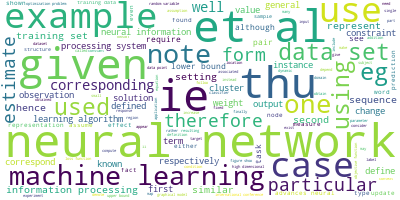

In [5]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

#### Prepare text for LDA analysis

LDA does not work directly on text data. First, it is necessary to convert the documents into a simple vector representation. This representation will then be used by LDA to determine the topics. Each entry of a 'document vector' will correspond with the number of times a word occurred in the document. In conclusion, we will convert a list of titles into a list of vectors, all with length equal to the vocabulary. For example, 'Analyzing machine learning trends with neural networks.' would be transformed into [1, 0, 1, ..., 1, 0].

We'll then plot the 10 most common words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud.

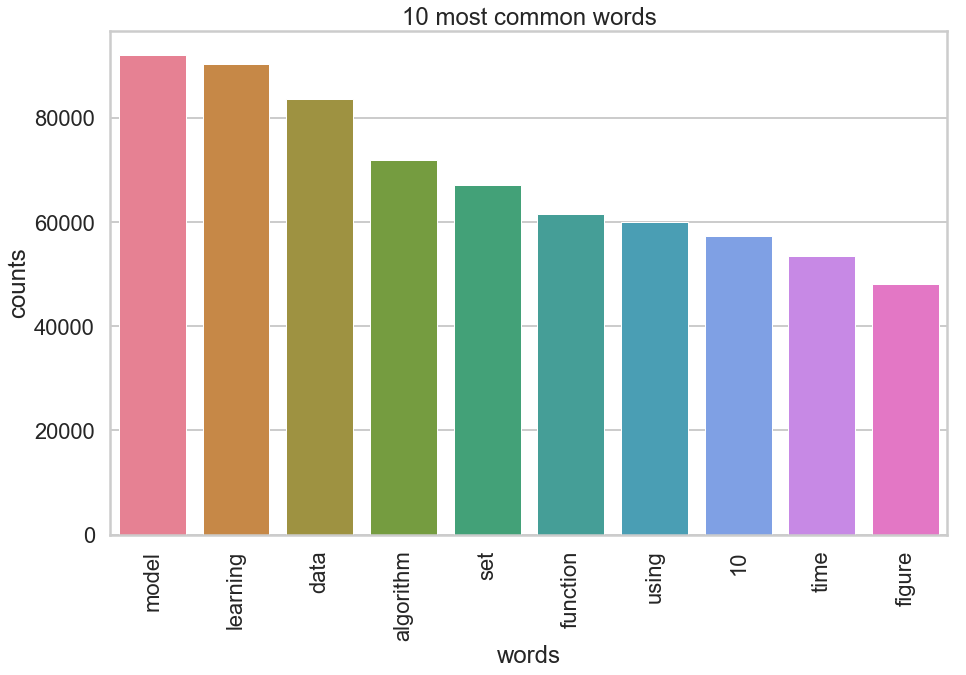

In [6]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(papers['paper_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [10]:
print count_data.shape
print papers.shape
count_data

(6560, 276406)
(6560, 5)


<6560x276406 sparse matrix of type '<type 'numpy.int64'>'
	with 5846691 stored elements in Compressed Sparse Row format>

#### LDA model tranining

The only parameter we will tweak is the number of topics in the LDA algorithm. Typically, one would calculate the 'perplexity' metric to determine which number of topics is best and iterate over different amounts of topics until the lowest 'perplexity' is found. We'll cover the model evaluation and tuning concept in the future articles

In [11]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5 # 可以计算散度perplexity，确定最佳的(最小时对应的)话题数目
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
learning data algorithm function set training problem 10 error kernel

Topic #1:
image learning features images training data model using object feature

Topic #2:
model algorithm learning state time set models function distribution number

Topic #3:
matrix data log algorithm model distribution gaussian 10 analysis noise

Topic #4:
model network neural figure input time networks learning data using


#### Analyzing our LDA model

pyLDAvis package is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The interactive visualization pyLDAvis produces is helpful for both:
1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most freqeuent and/or "relevant" terms, using different values of the λ parameter. This can help when you're trying to assign a human interpretable name or "meaning" to each topic.
For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [12]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

    with open(LDAvis_data_filepath, 'w') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

/Users/gongjing/usr/anaconda2/lib/python2.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


CPU times: user 2min 20s, sys: 21 s, total: 2min 41s
Wall time: 2min 30s


In [16]:
# 对于生成的这个文件，完全看不懂是什么内容

# gongjing@hekekedeiMac ~/SeafileSyn/github/blog_codes/notebooks (git)-[master] % head ldavis_prepared_5
# ccopy_reg
# _reconstructor
# p0
# (cpyLDAvis._prepare
# PreparedData
# p1
# c__builtin__
# tuple
# p2
# (g0
# gongjing@hekekedeiMac ~/SeafileSyn/github/blog_codes/notebooks (git)-[master] % tail ldavis_prepared_5
# s(lp772
# I5
# aI1
# aI3
# aI4
# aI2
# atp773
# tp774
# Rp775
# .%

# file:///Users/gongjing/SeafileSyn/github/blog_codes/notebooks/ldavis_prepared_5.html
# 这个也不能直接在浏览器（chrome、safiri）打开